## Stock Market Forecasting Using Stacked LSTM

For this deep learning project, we will use stacked LSTM for stock prices forecasting.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### Data Collection

The stock market data that we will use is obtained via Tiingo API.

Source: https://api.tiingo.com/documentation/general/overview

To get access to the API token, you will need to register an account.
After that, run the cell below to get the data.

In [2]:
'''
import pandas_datareader as pdr
key=""                                             # Your API token
df = pdr.get_data_tiingo('AAPL', api_key=key)      # API provided by pandas datareader to get the data from Tiingo
'''

'\nimport pandas_datareader as pdr\nkey=""                                             # Your API token\ndf = pdr.get_data_tiingo(\'AAPL\', api_key=key)      # API provided by pandas datareader to get the data from Tiingo\n'

In [3]:
# df.to_csv('AAPL.csv')

In [4]:
df = pd.read_csv('AAPL.csv')
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-09-13 00:00:00+00:00,159.65,159.960,157.910,159.870,44393752,37.877496,37.951045,37.464675,37.929692,177575008,0.0,1.0
1,AAPL,2017-09-14 00:00:00+00:00,158.28,159.400,158.090,158.990,23073646,37.552459,37.818183,37.507381,37.720909,92294584,0.0,1.0
2,AAPL,2017-09-15 00:00:00+00:00,159.88,160.970,158.000,158.470,48203642,37.932064,38.190671,37.486028,37.597537,192814568,0.0,1.0
3,AAPL,2017-09-18 00:00:00+00:00,158.67,160.500,157.995,160.110,27939718,37.644988,38.079162,37.484842,37.986633,111758872,0.0,1.0
4,AAPL,2017-09-19 00:00:00+00:00,158.73,159.770,158.440,159.510,20347352,37.659223,37.905967,37.590420,37.844281,81389408,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,AAPL,2022-09-02 00:00:00+00:00,155.81,160.362,154.965,159.750,76957768,155.810000,160.362000,154.965000,159.750000,76957768,0.0,1.0
1253,AAPL,2022-09-06 00:00:00+00:00,154.53,157.090,153.690,156.470,73295539,154.530000,157.090000,153.690000,156.470000,73295539,0.0,1.0
1254,AAPL,2022-09-07 00:00:00+00:00,155.96,156.670,153.610,154.825,87449574,155.960000,156.670000,153.610000,154.825000,87449574,0.0,1.0
1255,AAPL,2022-09-08 00:00:00+00:00,154.46,156.360,152.680,154.640,84923847,154.460000,156.360000,152.680000,154.640000,84923847,0.0,1.0


### Data Visualisation

To make things simple, we consider the closing prices in the 'close' column.

The closing price is the raw price or cash value of the last transacted price in a security before the market officially closes for normal trading. It is often the reference point used by investors to compare a stock's performance since the previous day.

Source: https://www.investopedia.com/terms/c/closingprice.asp

In [5]:
close_df = pd.DataFrame(df['close'])
close_df

,close
0,159.65
1,158.28
2,159.88
3,158.67
4,158.73
...,...
1252,155.81
1253,154.53
1254,155.96
1255,154.46


We will visualise the values with a line plot.

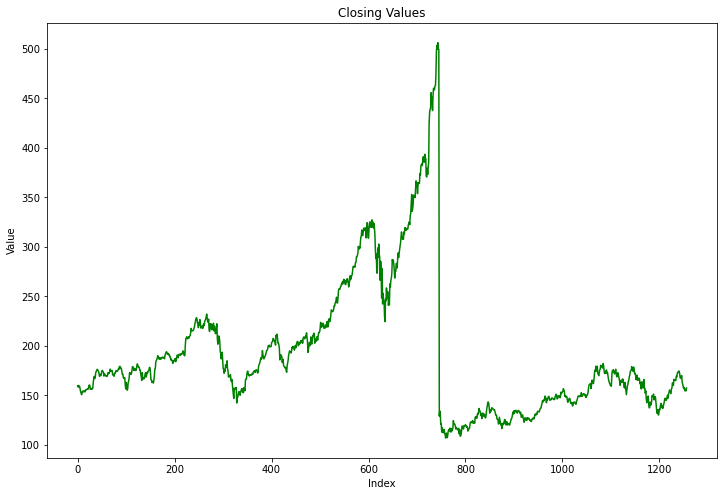

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(close_df, '-g')
plt.title('Closing Values')
plt.xlabel('Index')
plt.ylabel('Value')

plt.show()

First, we examine the measure of dispersion and central tendency of these values.

In [7]:
close_df.describe().round(2)

,close
count,1257.00
mean,192.01
std,68.43
min,106.84
25%,148.71
50%,172.97
75%,209.68
max,506.09


The range = max - min is quite large and 50% of the data is below 172.97.
Since we have a fixed min and max, we will apply MinMax scaler provided by sklearn as LTSM is sensitive to the scale of the data. It also helps the model to converge faster during training.

### Data Normalisation

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))                        # Scale the values to between 0 and 1 inclusive
close_df = scaler.fit_transform(np.array(close_df).reshape(-1,1)) # The argument is an array of 1 column

In [10]:
print(close_df)

[[0.13227301]
 [0.12884158]
 [0.13284909]
 ...
 [0.12303068]
 [0.11927364]
 [0.1265623 ]]


### Model Training

Now, we will split the data into train and test sets.

In [11]:
train_size = int(len(close_df)*0.65)      # Around 65% of the data are training data
test_size = len(close_df)-train_size      # Around 35% of the data are testing data
train_data, test_data = close_df[0:train_size,:], close_df[train_size:len(close_df),:1]
print('Train:', train_size) 
print('Test:', test_size)

Train: 817
Test: 440


For our prediction, we will use the previous 100-days input values to predict the next day value. So, if we have 1st: 112, 2nd: 135, ..., 100th: 154, to predict the 101th, we will use the 1st, 2nd, ..., 99th values.

In [12]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i + time_step), 0]        # When i=0, we will choose 100 values (0th,1st,2nd,...,99th)
                                                 # When i=1, we will choose 100 values (1st,2nd,3rd,...,100th)
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # When i=0, the 100th value will go into dataY
                                                 # When i=1, the 101th value will go into dataY
    return np.array(dataX), np.array(dataY)

In [13]:
# Reshape into X=t,t+1,t+2,...,t+99 and Y=t+100
time_step = 100  # Previous 100-day input values
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [14]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [15]:
print(X_test.shape), print(y_test.shape)

(339, 100)
(339,)


(None, None)

In [16]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

Now we will import relevant libraries to create LSTM.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [18]:
# Create the Stacked LSTM model
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1), activation='sigmoid'))   # First layer: LSTM
model.add(LSTM(50,return_sequences=True))                                             # Second layer: LSTM
model.add(LSTM(50))                                                                   # Third layer: LSTM
model.add(Dense(1, activation='sigmoid'))                                             # Fourth layer: Dense
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


Sigmoid activation function is chosen on the first layer because it bounds the output in the range [0, 1]. Previously, we have already normalised the data to be in the range [0, 1].

In [19]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=2)

Epoch 1/100
12/12 - 8s - loss: 0.0401 - val_loss: 0.0407 - 8s/epoch - 637ms/step
Epoch 2/100
12/12 - 2s - loss: 0.0365 - val_loss: 0.0298 - 2s/epoch - 165ms/step
Epoch 3/100
12/12 - 2s - loss: 0.0371 - val_loss: 0.0273 - 2s/epoch - 165ms/step
Epoch 4/100
12/12 - 2s - loss: 0.0364 - val_loss: 0.0326 - 2s/epoch - 159ms/step
Epoch 5/100
12/12 - 2s - loss: 0.0360 - val_loss: 0.0292 - 2s/epoch - 157ms/step
Epoch 6/100
12/12 - 2s - loss: 0.0357 - val_loss: 0.0314 - 2s/epoch - 160ms/step
Epoch 7/100
12/12 - 2s - loss: 0.0353 - val_loss: 0.0373 - 2s/epoch - 160ms/step
Epoch 8/100
12/12 - 2s - loss: 0.0333 - val_loss: 0.0111 - 2s/epoch - 158ms/step
Epoch 9/100
12/12 - 2s - loss: 0.0285 - val_loss: 0.0223 - 2s/epoch - 160ms/step
Epoch 10/100
12/12 - 2s - loss: 0.0257 - val_loss: 0.0163 - 2s/epoch - 158ms/step
Epoch 11/100
12/12 - 2s - loss: 0.0273 - val_loss: 0.0256 - 2s/epoch - 160ms/step
Epoch 12/100
12/12 - 2s - loss: 0.0215 - val_loss: 0.0178 - 2s/epoch - 158ms/step
Epoch 13/100
12/12 - 2s -

Epoch 100/100
12/12 - 2s - loss: 0.0020 - val_loss: 0.0016 - 2s/epoch - 160ms/step


### Model Prediction

Now, let us check the prediction and its performance metrics.

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 32ms/step


In [21]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

We will calculate the root mean squared error (RMSE) to determine how well the model performs.

In [22]:
from sklearn.metrics import mean_squared_error as mse

In [23]:
print('Train set:', np.sqrt(mse(y_train, train_predict)).round(3))  # Train set
print('Test set:', np.sqrt(mse(y_test, test_predict)).round(3))   # Test set

Train set: 228.333
Test set: 148.684


Now, let us plot the predictions and the actual values.

For the shifting of train predictions, since we are using 100-value look back, the results in train_predict will be from indices 100th,101th,... as compared to the original data, provided the index in the original data starts from 0.

For the shifting of test predictions, since the test set are taken after the train set, the indices will be from the size of train set + 100-day until the end of the original data.

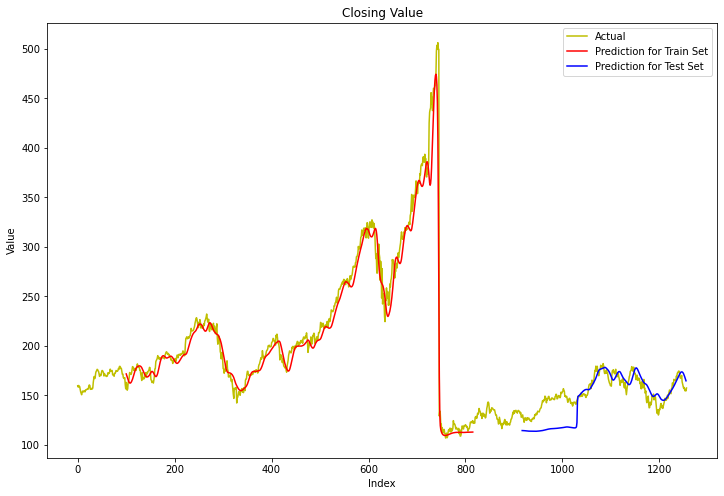

In [24]:
# Shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
testPredictPlot[len(train_data)+look_back:len(close_df)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 8))
plt.plot(scaler.inverse_transform(close_df), '-y', label='Actual')   # Actual values before transform
plt.plot(trainPredictPlot, '-r', label='Prediction for Train Set')   # Predictions for train set
plt.plot(testPredictPlot, '-b', label='Prediction for Test Set')     # Predictions for test set
plt.title('Closing Value')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

### Forecasting

It is time for the real input test.

In [25]:
x_input = test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [26]:
temp_input = list(x_input)[0].tolist()
temp_input

[0.15168440826549778,
 0.15125860989355033,
 0.14922980588603624,
 0.13763306199123349,
 0.140363180964308,
 0.1251346274264245,
 0.12455854727614268,
 0.14226675015654344,
 0.12726361928616153,
 0.12804007514088916,
 0.13184721352536,
 0.14822792736380713,
 0.12505948653725735,
 0.12633688165309953,
 0.11326236693800873,
 0.11939887288666245,
 0.09933625547902314,
 0.08946775203506574,
 0.10086412022542268,
 0.09693174702567309,
 0.10619912335629306,
 0.08510958046336875,
 0.0764182842830306,
 0.07701941139636814,
 0.09084533500313086,
 0.08395742016280527,
 0.0843581715716969,
 0.09252348152786471,
 0.10720100187852216,
 0.10519724483406384,
 0.10487163431433938,
 0.11113337507827176,
 0.09653099561678141,
 0.09843456480901686,
 0.10487163431433938,
 0.10299311208515965,
 0.0896681277395115,
 0.07586725109580456,
 0.0627175954915466,
 0.06492172824045078,
 0.07160926737633061,
 0.05815904821540385,
 0.061916092673763246,
 0.0727113337507827,
 0.07140889167188474,
 0.07872260488415778

We will test the prediction for the next 30 days.

In [27]:
# Demonstrate prediction for next 30 days
from numpy import array

lst_output = []
n_steps = x_input.shape[1]
i = 0
for i in range(30):
    
    if(len(temp_input) > 100):
        # print(temp_input)
        x_input = np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())

# print(lst_output)

In [28]:
day_new = np.arange(1, x_input.shape[1]+1)
day_pred = np.arange(x_input.shape[1]+1, x_input.shape[1]+31)

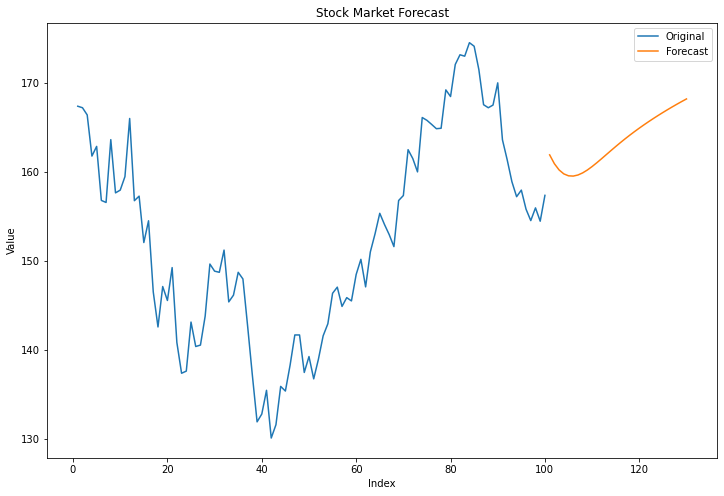

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(day_new, scaler.inverse_transform(close_df[len(close_df)-x_input.shape[1]:]), label='Original')
plt.plot(day_pred, scaler.inverse_transform(lst_output), label='Forecast')
plt.title('Stock Market Forecast')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

After the forecasting, we can join the data to the original dataset.

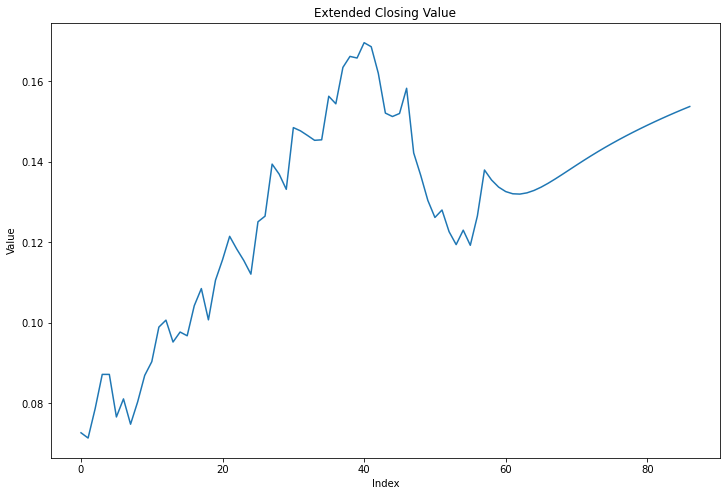

In [30]:
newCLOSE_df = close_df.tolist()
newCLOSE_df.extend(lst_output)

plt.figure(figsize=(12, 8))
plt.plot(newCLOSE_df[1200:])
plt.title('Extended Closing Value')
plt.xlabel('Index')
plt.ylabel('Value')

plt.show()

The final step is to transform the normalised data back to its original values.

In [31]:
newCLOSE_df = scaler.inverse_transform(newCLOSE_df).tolist()

Let us look at the complete line plot.

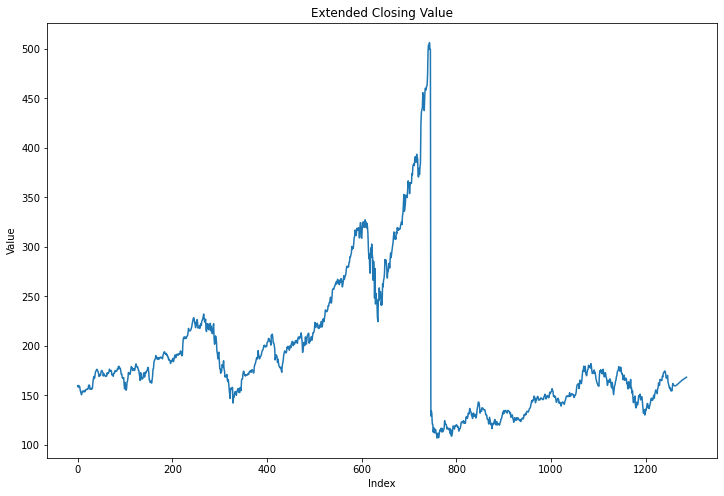

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(newCLOSE_df)
plt.title('Extended Closing Value')
plt.xlabel('Index')
plt.ylabel('Value')

plt.show()

Note: This deep learning method for stock market forecast should not be used as a reference for real stock investment. The real stock market is affected by many other factors, beyond the scope of what deep learning can provide.

### Extra: Removing the last 30 days and forecast those days

In this section, instead of forecasting the future 30 days, we will remove the last 30-day values in the dataset. Then, we will predict those values and determine its metrics.

In [33]:
close_df = pd.DataFrame(df['close'])

In [34]:
reducedCLOSE_df = pd.DataFrame(close_df[:len(df)-30])
reducedCLOSE_df

,close
0,159.65
1,158.28
2,159.88
3,158.67
4,158.73
...,...
1222,154.09
1223,152.95
1224,151.60
1225,156.79


In [35]:
scaler = MinMaxScaler(feature_range=(0,1))    # Scale the values to between 0 and 1 inclusive
reducedCLOSE_df = scaler.fit_transform(np.array(reducedCLOSE_df).reshape(-1,1))

In [36]:
train_size = int(len(reducedCLOSE_df)*0.65)
test_size = len(reducedCLOSE_df)-train_size
train_data, test_data = reducedCLOSE_df[0:train_size,:], reducedCLOSE_df[train_size:len(reducedCLOSE_df),:1]
print('Train:', train_size)
print('Test:', test_size)

Train: 797
Test: 430


In [37]:
# Reshape into X=t,t+1,t+2,...,t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [38]:
print(X_train.shape), print(y_train.shape)

(696, 100)
(696,)


(None, None)

In [39]:
print(X_test.shape), print(y_test.shape)

(329, 100)
(329,)


(None, None)

In [40]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [41]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1), activation='sigmoid'))     # First layer: LSTM
model.add(LSTM(50,return_sequences=True))                                               # Second layer: LSTM
model.add(LSTM(50))                                                                     # Third layer: LSTM
model.add(Dense(1, activation='sigmoid'))                                               # Fourth layer: Dense
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=2)

Epoch 1/100
11/11 - 7s - loss: 0.0462 - val_loss: 0.0272 - 7s/epoch - 671ms/step
Epoch 2/100
11/11 - 2s - loss: 0.0357 - val_loss: 0.0443 - 2s/epoch - 155ms/step
Epoch 3/100
11/11 - 2s - loss: 0.0354 - val_loss: 0.0327 - 2s/epoch - 159ms/step
Epoch 4/100
11/11 - 2s - loss: 0.0356 - val_loss: 0.0414 - 2s/epoch - 158ms/step
Epoch 5/100
11/11 - 2s - loss: 0.0354 - val_loss: 0.0316 - 2s/epoch - 161ms/step
Epoch 6/100
11/11 - 2s - loss: 0.0354 - val_loss: 0.0355 - 2s/epoch - 158ms/step
Epoch 7/100
11/11 - 2s - loss: 0.0352 - val_loss: 0.0395 - 2s/epoch - 160ms/step
Epoch 8/100
11/11 - 2s - loss: 0.0350 - val_loss: 0.0367 - 2s/epoch - 158ms/step
Epoch 9/100
11/11 - 2s - loss: 0.0344 - val_loss: 0.0333 - 2s/epoch - 155ms/step
Epoch 10/100
11/11 - 2s - loss: 0.0337 - val_loss: 0.0235 - 2s/epoch - 161ms/step
Epoch 11/100
11/11 - 2s - loss: 0.0294 - val_loss: 0.0025 - 2s/epoch - 164ms/step
Epoch 12/100
11/11 - 2s - loss: 0.0327 - val_loss: 0.0231 - 2s/epoch - 160ms/step
Epoch 13/100
11/11 - 2s -

Epoch 100/100
11/11 - 2s - loss: 0.0012 - val_loss: 3.2738e-04 - 2s/epoch - 174ms/step


In [43]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 31ms/step


In [44]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [45]:
print('Train set:', np.sqrt(mse(y_train, train_predict)).round(3))  # Train set
print('Test set:', np.sqrt(mse(y_test, test_predict)).round(3))    # Test set

Train set: 236.805
Test set: 154.758


In [46]:
x_input = test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [47]:
temp_input = list(x_input)[0].tolist()
temp_input

[0.13139636819035688,
 0.1267376330619912,
 0.1405385097056981,
 0.12944270507201,
 0.11994990607388845,
 0.10965560425798371,
 0.12085159674389478,
 0.13212273011897302,
 0.13470256731371316,
 0.14311834690043823,
 0.14662492172824038,
 0.1552410770194113,
 0.1587226048841578,
 0.16839073262366933,
 0.17001878522229175,
 0.17222291797119593,
 0.18063869755792106,
 0.1776581089542893,
 0.16974326862867878,
 0.16899185973700687,
 0.1793362554790231,
 0.17087038196618654,
 0.16278021289918598,
 0.1635566687539135,
 0.158422041327489,
 0.14755165936130238,
 0.1523356293049467,
 0.15919849718221663,
 0.14639949906073885,
 0.1458484658735128,
 0.15168440826549778,
 0.15125860989355033,
 0.14922980588603624,
 0.13763306199123349,
 0.140363180964308,
 0.1251346274264245,
 0.12455854727614268,
 0.14226675015654344,
 0.12726361928616153,
 0.12804007514088916,
 0.13184721352536,
 0.14822792736380713,
 0.12505948653725735,
 0.12633688165309953,
 0.11326236693800873,
 0.11939887288666245,
 0.09933

In [48]:
# Demonstrate prediction for next 30 days
from numpy import array

lst_output = []
n_steps = x_input.shape[1]
i = 0
for i in range(30):
    
    if(len(temp_input) > 100):
        # print(temp_input)
        x_input = np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())

# print(lst_output)

In [49]:
day_new = np.arange(1, x_input.shape[1]+1)
day_pred = np.arange(x_input.shape[1]+1, x_input.shape[1]+31)

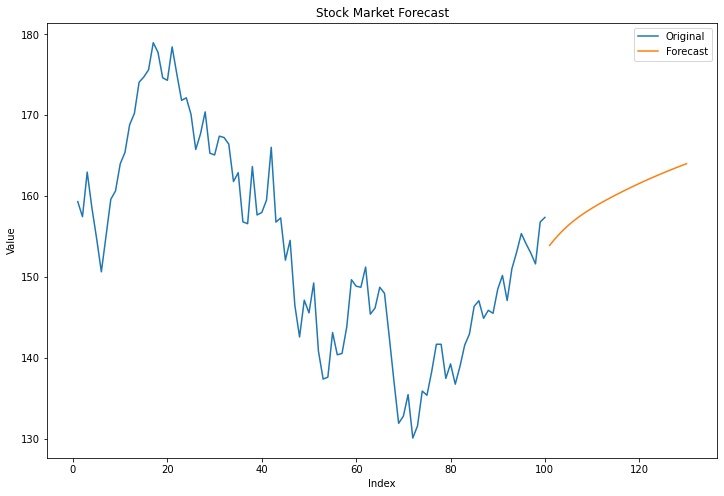

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(day_new, scaler.inverse_transform(reducedCLOSE_df[len(reducedCLOSE_df)-x_input.shape[1]:]), label='Original')
plt.plot(day_pred, scaler.inverse_transform(lst_output), label='Forecast')
plt.title('Stock Market Forecast')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

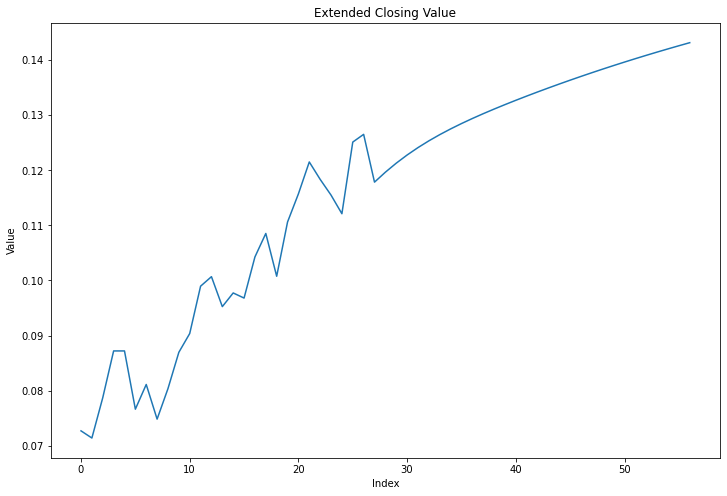

In [51]:
newCLOSE_df = reducedCLOSE_df.tolist()
newCLOSE_df.extend(lst_output)

plt.figure(figsize=(12, 8))
plt.plot(newCLOSE_df[1200:])
plt.title('Extended Closing Value')
plt.xlabel('Index')
plt.ylabel('Value')

plt.show()

In [52]:
newCLOSE_df = scaler.inverse_transform(newCLOSE_df).tolist()

In [53]:
newCLOSE_df = pd.DataFrame(newCLOSE_df)
newCLOSE_df.columns = ['close']

In [54]:
newCLOSE_df

,close
0,159.650000
1,158.280000
2,159.880000
3,158.670000
4,158.730000
...,...
1252,163.074550
1253,163.310772
1254,163.542146
1255,163.768826


In [55]:
y_bound = newCLOSE_df.iloc[len(newCLOSE_df)-30, 0]

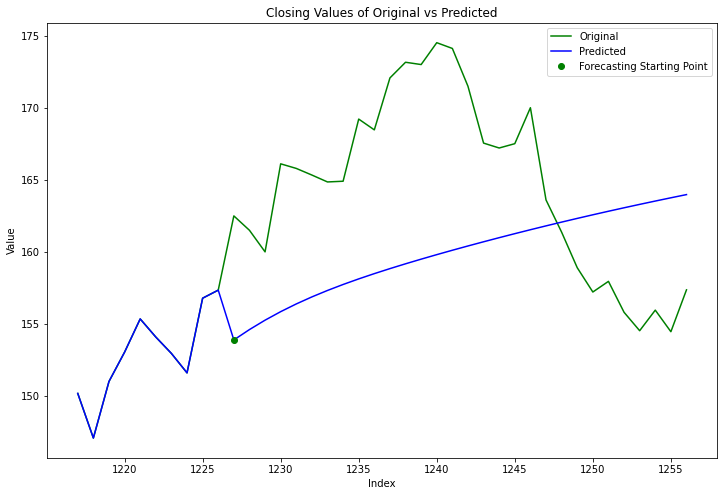

In [56]:
plt.figure(figsize=(12, 8))
plt.plot(close_df[len(close_df)-40:], '-g', label='Original')
plt.plot(newCLOSE_df[len(newCLOSE_df)-40:], '-b', label='Predicted')
plt.plot(len(newCLOSE_df)-30, y_bound, 'go', label='Forecasting Starting Point')
plt.title('Closing Values of Original vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

Lastly, we will look at the root mean squared error for the 30-day predicted values.

In [57]:
mse_value = mse(close_df[len(close_df)-30:], newCLOSE_df[len(newCLOSE_df)-30:])
print('RMSE:', np.sqrt(mse_value).round(3))

RMSE: 8.976
